# 求解十字激光端点与交点

1Z实验室出品
**1ZLAB ：Make Things Easy**

程序目标

获取十字的中心还有四个端点的坐标
![cross-laser-demo.png](./cross-laser-demo.png)

In [1]:
import cv2

In [2]:
gray = cv2.imread('shizi.bmp', cv2.IMREAD_GRAYSCALE)

In [3]:
from matplotlib import pyplot as plt

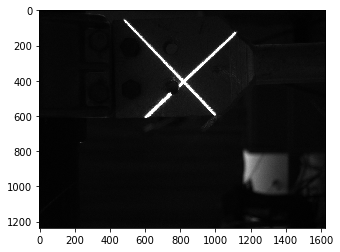

In [4]:
plt.imshow(gray, cmap='gray')
plt.show()

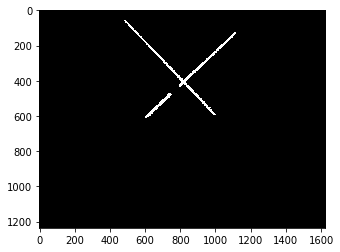

In [5]:
# TODO 其实可以考虑降低分辨率
binary = cv2.inRange(gray, 200, 255)

plt.imshow(binary, cmap='gray')
plt.show()


霍夫检测直线的文档
http://www.opencv.org.cn/opencvdoc/2.3.2/html/doc/tutorials/imgproc/imgtrans/hough_lines/hough_lines.html#hough-lines

In [6]:
# 返回的直线的两个端点
# 需要调这里面的阈值
# 返回的是线段的两个端点
line_segs = cv2.HoughLinesP(binary, rho=2,theta=0.1, threshold=100)
len(line_segs)

253

In [7]:
# 这段代码只是展示一下，可以删除
import math

for lseg in line_segs:
    # 
    x1,y1,x2,y2 = lseg[0]
    # 计算权重
    weight = math.sqrt(math.pow(x1-x2, 2) + math.pow(y1-y2, 2))
    print('x1: {}, y1: {}, x2: {}, y2: {}, weight: {}'.format(x1, y1, x2, y2, weight))
    

x1: 573, y1: 144, x2: 933, y2: 536, weight: 532.2255161113567
x1: 676, y1: 250, x2: 698, y2: 274, weight: 32.55764119219941
x1: 799, y1: 434, x2: 1113, y2: 129, weight: 437.74535976980957
x1: 792, y1: 437, x2: 1113, y2: 125, weight: 447.6438316340347
x1: 793, y1: 434, x2: 1112, y2: 124, weight: 444.8156921692399
x1: 817, y1: 408, x2: 1068, y2: 164, weight: 350.0528531522061
x1: 525, y1: 93, x2: 868, y2: 468, weight: 508.20665088131227
x1: 630, y1: 202, x2: 818, y2: 408, weight: 278.89065957826557
x1: 488, y1: 56, x2: 814, y2: 412, weight: 482.7131653477042
x1: 816, y1: 407, x2: 960, y2: 267, weight: 200.83824337013107
x1: 714, y1: 520, x2: 714, y2: 520, weight: 0.0
x1: 845, y1: 391, x2: 1113, y2: 131, weight: 373.39523296367884
x1: 698, y1: 275, x2: 817, y2: 404, weight: 175.50498568416796
x1: 484, y1: 54, x2: 731, y2: 324, weight: 365.9357867167408
x1: 602, y1: 611, x2: 745, y2: 472, weight: 199.42417105255822
x1: 755, y1: 331, x2: 820, y2: 402, weight: 96.26006440887103
x1: 601, y1: 

对线段进行加权
预备知识是假设已知画面中有两条线,根据线段长度进行加权，获取两个线段。
？用机器学习的方法？

In [8]:

def calculate_line(x1, y1, x2, y2):
    '''
    计算直线
    如果直线水平或者垂直，统一向一个方向倾斜特定角度。
    TODO 这里面没有考虑水平或者垂直的情况
    '''
    if x1 > x2:
        x1,y1,x2,y2 = x2,y2,x1,y1
    if x1 == x2 or y1 == y2:
        # 有时候会出现单个像素点 x1 = x2 而且 y1 = y2
        print('x1:{} y1:{} x2:{} y2:{}'.format(x1, y1, x2, y2))
    k = (y1 - y2) / (x1 - x2)
    b = (y2 * x1 - y1*x2) / (x1 - x2)
    
    return k,b

In [9]:
# BUG k b 改一个line，剩余的全改


lines = []
         
# 最小权值
min_weight = 20
# 相同k之间最大的差距
max_k_distance = 0.3

for lseg in line_segs:
    # 获取线段端点值
    x1,y1,x2,y2 = lseg[0]
    if x1 > x2:
        x1, y1, x2, y2 = x2, y2, x1, y1
        
    # 计算权重
    weight = math.sqrt(math.pow(x1 - x2, 2) + math.pow(y1 - y2, 2))
    
    if weight != 0 and weight > min_weight:
        # 计算K与b
        k, b = calculate_line(x1, y1, x2, y2)
        # print('k: {:.2f}, b: {:.2f}, weight: {:.2f}'.format(k, b, weight))
        
        if len(lines) == 0:
            # 初次填充line
            line = {}
            line['cur_k'] = k
            line['cur_b'] = b
            line['k_sum'] = k * weight
            line['b_sum'] = b * weight
            line['weight_sum'] = weight
            line['x1'] = x1
            line['y1'] = y1
            line['x2'] = x2
            line['y2'] = y2
            lines.append(line)
            continue
        
        # 根据k的差异做加权
        # 首先获取lines数组里面k举例最近的那个
        
        neighbor_line = min(lines, key=lambda line:abs(line['cur_k'] - k))
        
        if  abs(neighbor_line['cur_k'] - k) < max_k_distance:
            # 小于最大k差值，认为是同一条线
            
            neighbor_line['weight_sum'] += weight
            neighbor_line['k_sum'] += k * weight
            neighbor_line['b_sum'] += b * weight
            neighbor_line['cur_k'] = neighbor_line['k_sum'] / neighbor_line['weight_sum']
            neighbor_line['cur_b'] = neighbor_line['b_sum'] / neighbor_line['weight_sum']
            
            if neighbor_line['x1'] > x1:
                neighbor_line['x1'] = x1
                neighbor_line['y1'] = y1
                
            if neighbor_line['x2'] < x2:
                neighbor_line['x2'] = x2
                neighbor_line['y2'] = y2
            
        else:
            # 添加另外一条线
            # 初次填充line
            line = {}
            line['cur_k'] = k
            line['cur_b'] = b
            line['k_sum'] = k * weight
            line['b_sum'] = b * weight
            line['weight_sum'] = weight
            line['x1'] = x1
            line['y1'] = y1
            line['x2'] = x2
            line['y2'] = y2
            lines.append(line)


In [10]:
# 整合后的直线
print(len(lines))
lines

# TODO 如果len(lines)小于2 抛出异常

2


[{'b_sum': -3304027.8377846032,
  'cur_b': -482.1075439824276,
  'cur_k': 1.0900334200603314,
  'k_sum': 7470.32650483927,
  'weight_sum': 6853.300428555484,
  'x1': 478,
  'x2': 1001,
  'y1': 54,
  'y2': 597},
 {'b_sum': 8948293.312710544,
  'cur_b': 1209.7121822845368,
  'cur_k': -0.9799324921216083,
  'k_sum': -7248.603010345705,
  'weight_sum': 7397.043233715087,
  'x1': 599,
  'x2': 1113,
  'y1': 607,
  'y2': 129}]

在画面中绘制两条直线与四个顶点

In [11]:
# 根据权重对lines数组进行排序， 取前两个（lines的长度有可能大于2）
sorted_lines = sorted(lines, key=lambda line: line['weight_sum'])[::-1]
line1 = sorted_lines[0]
line2 = sorted_lines[1]
# 计算两个线之间的交点


In [12]:
def calculate_intersection(line1, line2):
    a1 = line1['y2'] - line1['y1']
    b1 = line1['x1'] - line1['x2']
    c1 = line1['x2'] * line1['y1'] - line1['x1'] * line1['y2']
    
    a2 = line2['y2'] - line2['y1']
    b2 = line2['x1'] - line2['x2']
    c2 = line2['x2'] * line2['y1'] - line2['x1'] * line2['y2']
    
    if (a1 * b2 - a2 * b1) != 0 and (a2 * b1 - a1 * b2) != 0:
        cross_x = int((b1*c2-b2*c1)/(a1*b2-a2*b1))
        cross_y = int((c1*a2-c2*a1)/(a1*b2-a2*b1))
        return (cross_x, cross_y)
    return None

In [13]:
(cx, cy) = calculate_intersection(line1, line2)
print('cx: {} cy: {}'.format(cx, cy))

cx: 816 cy: 405


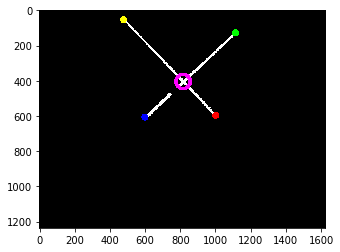

In [14]:
canvas = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

# 绘制第一条线
pt_radius = 20
cv2.circle(canvas, (line1['x1'], line1['y1']),pt_radius, (255, 0, 0), thickness=-1)
cv2.circle(canvas, (line1['x2'], line1['y2']),pt_radius, (0, 255, 0), thickness=-1)
cv2.circle(canvas, (line2['x1'], line2['y1']),pt_radius, (0, 255, 255), thickness=-1)
cv2.circle(canvas, (line2['x2'], line2['y2']),pt_radius, (0, 0, 255), thickness=-1)

cv2.circle(canvas, (cx, cy), 40, (255, 0, 255), thickness=20)

plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.show()